In [3]:
import numpy as np
from matplotlib import figure, gridspec,colors

import scanner_interpretation as scani

import healpy as hp

from matplotlib import colors,cm
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import visualization as vis

import dill

from gammapy.datasets import Datasets
from gammapy.data import DataStore,ObservationFilter

from pathlib import Path
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion, Regions



with open("pickles/mplets.pkl","rb") as f:
    mplets = dill.load(f)

nosource_mask = mplets.table["TEVCAT_DISTANCES_DEG"] >= 0.2
Nmin4_mask = mplets.table["Nmax"] >= 4
Nmin5_mask = mplets.table["Nmax"] >= 5
dt1sec_mask = mplets.table["dt"] <= 1e9
xgal_mask = np.abs(mplets.table["MEDIAN_GLAT"]) > 5

In [29]:
mymask = xgal_mask * nosource_mask
reduced = mplets.table[mymask]
obsids = reduced["OBS_ID"]

current_obs_index = 12000

hess1_datastore = DataStore.from_dir("$HESS1")
hess1u_datastore = DataStore.from_dir("$HESS1U")
myobs = hess1_datastore.get_observations([obsids[current_obs_index]])
phottable = myobs[0].events.table

run_dist = scani.sphere_dist(phottable["RA"].data, phottable["DEC"].data, reduced[current_obs_index]["MEDIAN_RA"], reduced[current_obs_index]["MEDIAN_DEC"])

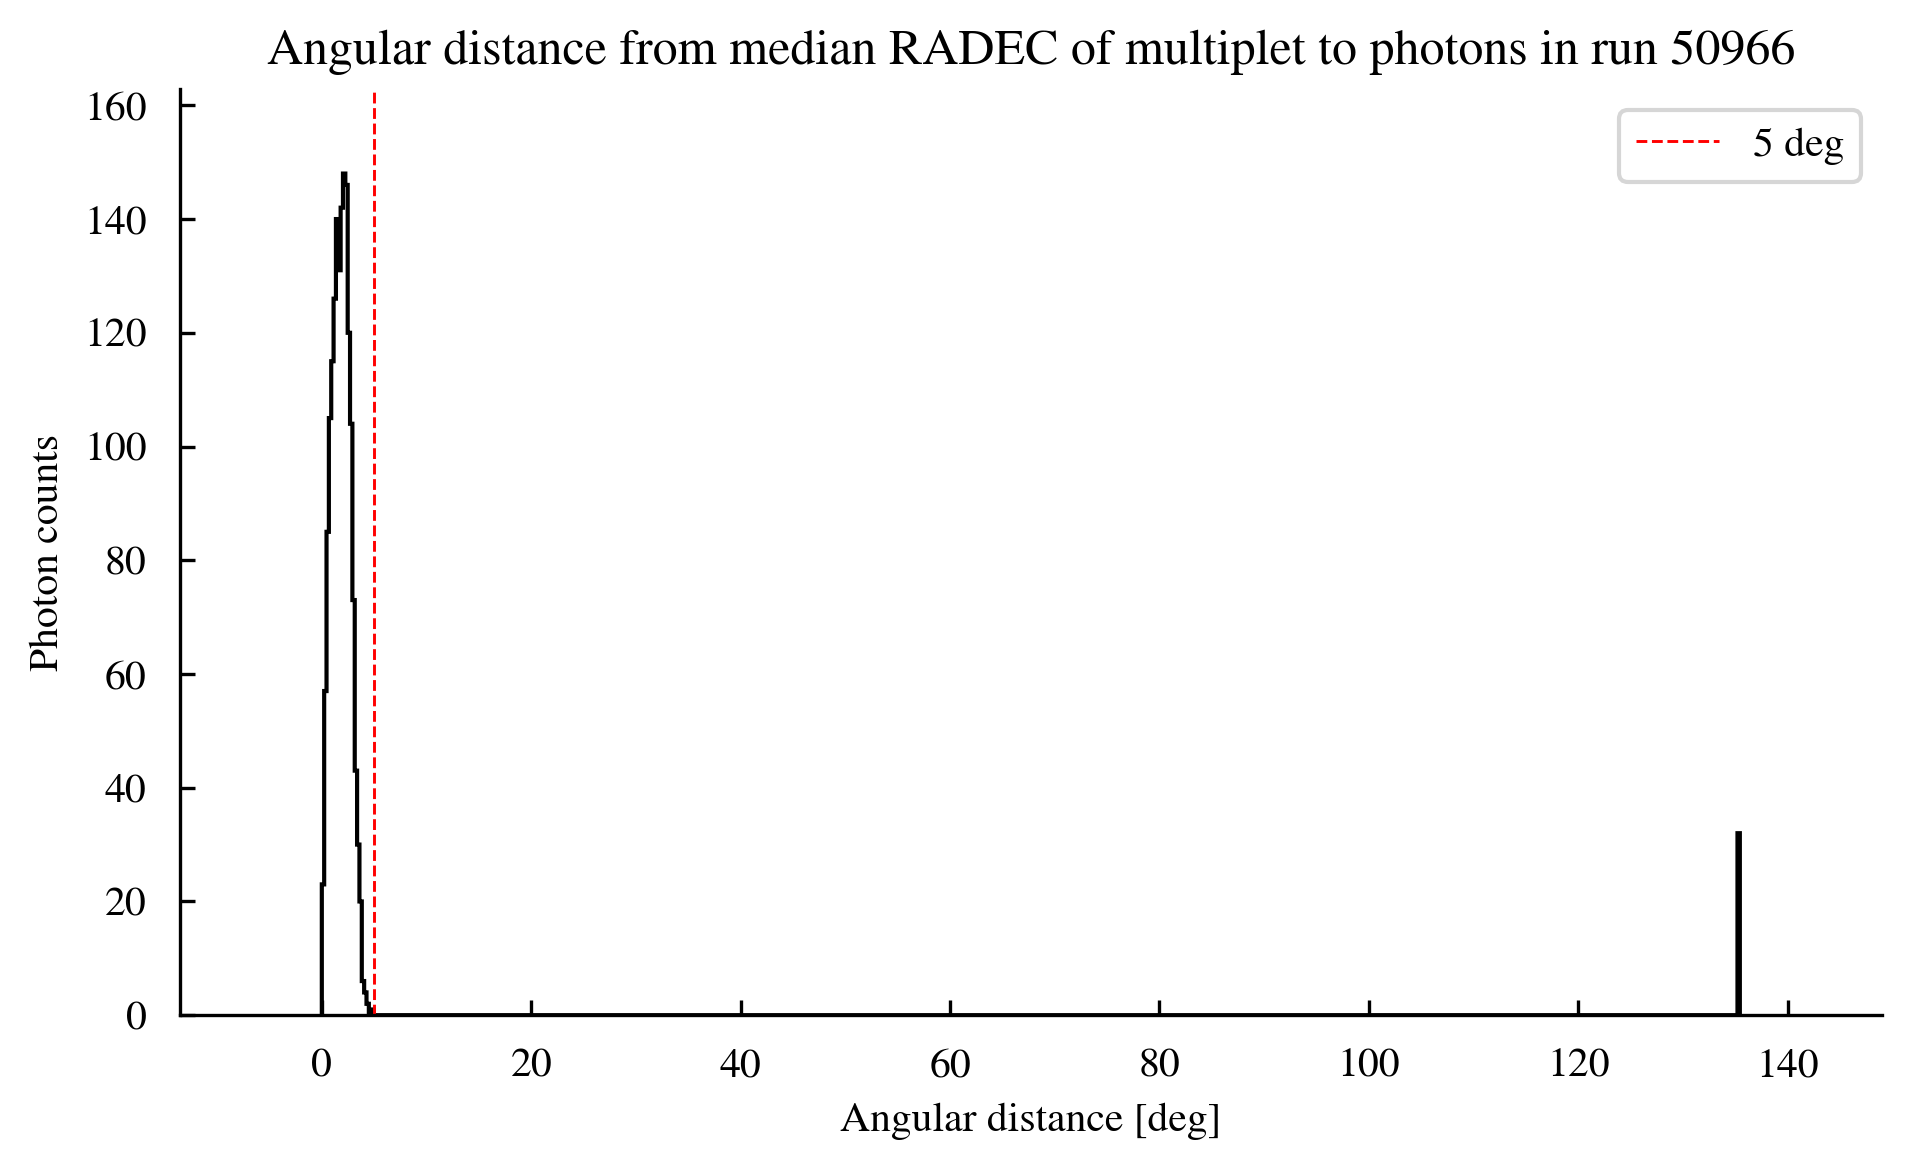

In [32]:
myhist = vis.hist(run_dist,histtype="step",bins="freedman")
plt.xlabel("Angular distance [deg]")
plt.ylabel("Photon counts")
plt.title(f"Angular distance from median RADEC of multiplet to photons in run {obsids[current_obs_index]}")
ax = plt.gca()
ylims = ax.get_ylim()
plt.vlines(5,ylims[0],ylims[1],color="red",ls="--",label="5 deg")
ax.set_ylim(*ylims)
plt.legend()
# plt.yscale("log")

In [34]:
mask = run_dist < 0.2
phottable[mask][:]

EVENT_ID,EVENT_ID_HESS,BUNCH_ID_HESS,OBS_ID,TIME,MULTIP,RA,DEC,DIR_ERR,SKYX_RADEC,SKYY_RADEC,DETX,DETY,FOV_ALTAZ_THETA,FOV_ALTAZ_PHI,FOV_ALTAZ_LON,FOV_ALTAZ_LAT,FOV_RADEC_THETA,FOV_RADEC_PHI,FOV_RADEC_LON,FOV_RADEC_LAT,ALT,AZ,COREX,COREY,CORE_ERR,XMAX,XMAX_ERR,ENERGY,ENERGY_ERR,HIL_MSW,HIL_MSW_ERR,HIL_MSL,HIL_MSL_ERR
,,,,s,,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,deg,m,m,m,m,m,TeV,TeV,,,,
int64,uint32,uint32,uint32,float64,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
184683594081,353,43,50966,262288671.12688422,2,136.4348,-11.034233,0.089434244,1.4011842,-0.054194327,0.26633883,1.3765459,1.4020703,100.94838,0.26633883,1.3765459,1.401952,-87.78504,-0.054194313,-1.4009044,77.60727,349.42282,-3.719777,136.6552,1e-45,153.68481,4.8964875e-08,0.32743144,1.0,-0.8823673,0.31349894,-0.98183644,0.4275821
206158430370,162,48,50966,262288689.77009678,2,136.5751,-10.943155,0.00015985513,1.310062,0.08357531,0.12308436,1.3068237,1.3126063,95.37965,0.12308436,1.3068237,1.3124956,-93.65023,0.08357525,-1.3098325,77.52795,349.7751,121.38177,93.056175,1e-45,323.1299,1.0028532e-07,0.2621505,1.0,-1.1443436,0.34285763,-0.7771185,0.34667715
249108103696,528,58,50966,262288732.76290274,2,136.37029,-10.944377,0.021223553,1.3112959,-0.11757064,0.33710846,1.2725482,1.3164355,104.8349,0.33710846,1.2725482,1.3163244,-84.876564,-0.117570475,-1.3110642,77.46111,348.05942,-77.43359,5.221641,1e-45,267.6176,5.613309e-08,0.26080957,1.0,-0.8627913,0.33966792,-1.0811082,0.3719232
304942678516,500,71,50966,262288784.8226099,2,136.42662,-11.063482,0.08669956,1.4304528,-0.062222276,0.3226802,1.3947966,1.4316282,103.02342,0.3226802,1.3947966,1.4315075,-87.5093,-0.06222225,-1.4301549,77.546165,347.23257,121.99138,76.52336,1e-45,317.01865,1.47764325e-08,0.19597927,1.0,-1.546837,0.32249603,-0.5284444,0.40012228
313532612838,230,73,50966,262288790.91551757,2,136.52818,-11.11101,0.05259887,1.4780068,0.037473973,0.23579234,1.4593564,1.4782784,99.17615,0.23579234,1.4593564,1.4781537,-91.45239,0.03747397,-1.4776788,77.608025,347.52704,127.733,19.681267,1e-45,239.16599,1.6887138e-07,0.53330296,1.0,-1.0477693,0.33426785,-1.085827,0.31923378
605590389302,566,141,50966,262289066.9752977,3,136.61974,-11.107055,0.008474276,1.4740746,0.12735331,0.25579736,1.4570838,1.4793618,99.954926,0.25579736,1.4570838,1.479237,-94.937836,0.1273531,-1.4737458,77.35482,342.86346,52.358307,-51.769203,1e-45,279.87292,0.19353554,0.39358634,1.0,-1.0259082,0.27898732,-0.9238738,0.2769033
648540061932,236,151,50966,262289105.0008216,2,136.54083,-11.071489,0.04647714,1.4384629,0.049904287,0.33554223,1.399492,1.439147,103.48007,0.33554223,1.399492,1.4390255,-91.98695,0.049904272,-1.4381602,77.25453,341.89136,14.499763,79.07106,1e-45,289.66287,1.0810202e-08,0.38807416,1.0,-0.88760215,0.31387645,-0.8606528,0.38016292
923417969082,442,215,50966,262289364.0063691,2,136.36359,-11.11062,0.037417036,1.4776399,-0.124087505,0.6050783,1.3535714,1.4826353,114.0814,0.6050783,1.3535714,1.4825101,-85.199745,-0.12408731,-1.477309,76.88123,336.62228,112.73683,72.052536,1e-45,193.47028,1.4546559e-08,0.28055105,1.0,-1.1220213,0.3256802,-0.6975007,0.4011699
